In [1]:
"""
Building and training a 50-layer Residual Network for multiclass classification
on sign language digit recognition (0–9)
"""

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, Flatten, BatchNormalization,
                                     Conv2D, AveragePooling2D, MaxPooling2D, Dropout)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, he_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

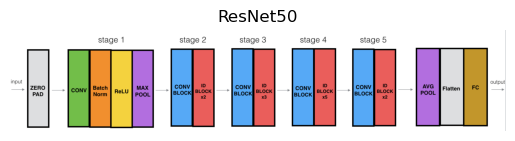

In [3]:
# BUILDING A RESIDUAL NETWORK
# Here is the picture of the residual network being built
rn_img_path = os.path.join(os.getcwd(), "images", "resnet50.png")
rn_image = plt.imread(rn_img_path)
plt.imshow(rn_image)
plt.axis('off')
plt.title("ResNet50")
plt.show()

**Note:** The following figure describes the architecture of the residual network. "ID BLOCK" in the diagram stands for
"Identity block" while "CONV BLOCK" stands for "Convolutional block." And "ID BLOCK x3" means stacking 3 ID BLOCKS.
Here is a look at the ID BLOCK and CONV BLOCK

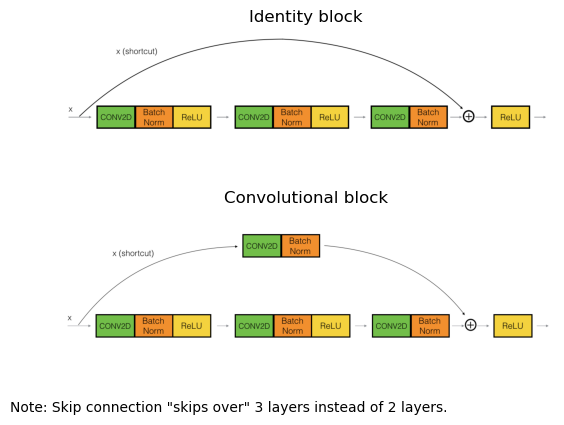

In [4]:
idblock_img_path = os.path.join(os.getcwd(), "images", "idblock3.png")
convblock_img_path = os.path.join(os.getcwd(), "images", "convblock.png")

fig, ax = plt.subplots(2, 1)
ax[0].imshow(plt.imread(idblock_img_path))
ax[0].set_title('Identity block')
ax[0].axis('off')
ax[1].imshow(plt.imread(convblock_img_path))
ax[1].set_title('Convolutional block')
ax[1].axis('off')
fig.text(0.05, 0.02, 'Note: Skip connection "skips over" 3 layers instead of 2 layers.')
plt.show()

In [5]:
# Building the various blocks
# Identity block
def identity_block(X, f, filters, initializer=he_uniform, training=None):
    """
    Implementation of the identity block as defined in the figure

    Arguments:
        X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f -- integer, specifying the shape of the middle CONV's window for the main path
        filters -- python list of integers, defining the number of filters in the CONV layers of the main path
        initializer -- initializer for the kernel weights of the convolutional layers
        training -- boolean, training mode (True) or testing (False)

    Returns:
        X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters for each CONV layer
    F1, F2, F3 = filters

    # Save the input value for later addition (skip connection)
    X_shortcut = X

    # First component of the main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer)(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Normalize the output along the channels axis
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer=initializer)(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer)(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Add the shortcut value to the main path and apply the final ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [6]:
def convolutional_block(X, f, filters, s=2, initializer=he_uniform, training=None):
    """
    Implementation of the convolutional block as defined in the figure

    Arguments:
        X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f -- integer, specifying the shape of the middle CONV's window for the main path
        filters -- python list of integers, defining the number of filters in the CONV layers of the main path
        s -- Integer, specifying the stride to be used
        initializer -- initializer for the kernel weights of the convolutional layers
        training -- boolean, training mode (True) or testing (False)

    Returns:
        X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters for each CONV layer
    F1, F2, F3 = filters

    # Save the input value for later addition (skip connection)
    X_shortcut = X

    # Main path
    # First component of the main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer)(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Normalize the output along the channels axis
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer=initializer)(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer)(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Shortcut path
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s, s), padding='valid',
                        kernel_initializer=initializer)(X_shortcut)

    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Combining path and passing it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [29]:
# Building the model
def ResNet50(input_shape=(64, 64, 3), num_class=10, dropout_rate=0.3, training=None):
    """
    Stage-wise implementation of the popular ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
        input_shape -- shape of the images of the dataset
        num_class -- integer, number of classes
        training -- boolean, training mode (True) or testing (False)

    Returns:
        model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform)(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1, training=training)
    X = identity_block(X, 3, [64, 64, 256], training=training)
    X = identity_block(X, 3, [64, 64, 256], training=training)

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2, training=training)
    X = identity_block(X, 3, [128, 128, 512], training=training)
    X = identity_block(X, 3, [128, 128, 512], training=training)
    X = identity_block(X, 3, [128, 128, 512], training=training)

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2, training=training)
    X = identity_block(X, 3, [256, 256, 1024], training=training)
    X = identity_block(X, 3, [256, 256, 1024], training=training)
    X = identity_block(X, 3, [256, 256, 1024], training=training)
    X = identity_block(X, 3, [256, 256, 1024], training=training)
    X = identity_block(X, 3, [256, 256, 1024], training=training)

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2, training=training)
    X = identity_block(X, 3, [512, 512, 2048], training=training)
    X = identity_block(X, 3, [512, 512, 2048], training=training)

    # Final Step
    X = AveragePooling2D(pool_size=(2,2))(X)
    X = Flatten()(X)
    X = Dropout(rate=dropout_rate)(X, training=training)
    X = Dense(num_class, activation='softmax', kernel_initializer=glorot_uniform)(X)

    # Create model
    resnet_model = Model(inputs=X_input, outputs=X)

    return resnet_model

In [8]:
# LOADING  THE DATASET
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
IMG_SHAPE = IMG_SIZE + (3,)
directory = os.path.join(os.getcwd(), 'Sign-Language-Digits-Dataset')

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             labels='inferred',  # Auto infer labels based on subdirectory names
                                             seed=SEED)

validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.3,
                                                  subset='validation',
                                                  labels='inferred',  # Auto infer labels based on subdirectory names
                                                  seed=SEED)

# Let's print the class names to see the class labels
class_names = train_dataset.class_names
print('The classes: {}'.format(class_names))

Found 2062 files belonging to 10 classes.
Using 1444 files for training.
Found 2062 files belonging to 10 classes.
Using 618 files for validation.
The classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [9]:
# Further split validation set into validation and test datasets
print("Training batches:", train_dataset.cardinality().numpy())
print("Batches to split into validation and test dataset:", validation_dataset.cardinality().numpy())

Training batches: 46
Batches to split into validation and test dataset: 20


In [10]:
from collections import Counter

def get_class_distribution(dataset, dataset_name="Test Dataset"):
    """
    Computes the total class distribution from a dataset.

    Arguments:
        dataset -- A TensorFlow dataset containing image-label pairs.
        dataset_name -- A string indicating the name of the dataset. Default is "Test Dataset".

    Returns:
        sorted_label_counts -- A dictionary with sorted class labels (as strings) and their counts.
    """
    total_label_counts = Counter()

    # Loop through all batches and accumulate class counts
    for i, (images, labels) in enumerate(dataset):
        batch_counts = Counter(labels.numpy())  # Count classes per batch
        total_label_counts.update(batch_counts)  # Aggregate counts

    # Sort dictionary by key and convert keys to strings
    sorted_label_counts = {str(k): v for k, v in sorted(total_label_counts.items())}

    # Print final sorted class distribution
    print(f"{dataset_name} total class distribution: \n{sorted_label_counts}")

    return sorted_label_counts

In [11]:
# Verify class distributions
val_class_distribution = get_class_distribution(train_dataset, "Train dataset")
test_class_distribution = get_class_distribution(validation_dataset, "Validation dataset")

Train dataset total class distribution: 
{'0': 149, '1': 152, '2': 152, '3': 138, '4': 142, '5': 143, '6': 143, '7': 152, '8': 135, '9': 138}
Validation dataset total class distribution: 
{'0': 56, '1': 54, '2': 54, '3': 68, '4': 65, '5': 64, '6': 64, '7': 54, '8': 73, '9': 66}


2025-05-12 15:20:14.684742: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-12 15:20:14.743294: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Note:** The class frequencies are relatively close for each dataset.
There's no extreme imbalance, which helps ensure reliable model evaluation.

In [12]:
# Extract the first element from the mini-batch
first_batch = train_dataset.take(1)
for images, labels in first_batch:
    first_image = images[0]
    first_label = labels[0]
    break

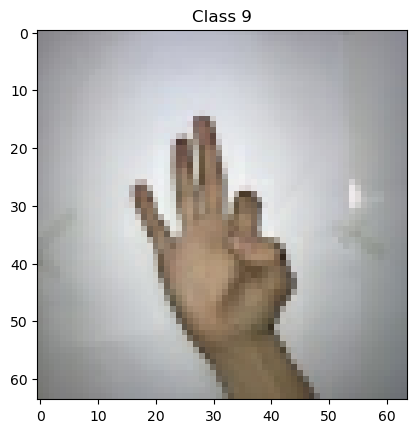

In [13]:
# Visualize image
first_image = first_image / 255.  # Clipping input data to the valid range [0, 1]
plt.imshow(first_image)
plt.title(f"Class {first_label}")
plt.show()

In [14]:
# TRAINING THE MODEL
# Create TensorFlow dataset objects
num_classes = len(class_names)
image_shape = first_image.shape
print("The number of classes in the dataset:", num_classes)  # Output: 10
print("Input image shape:", image_shape)  # Output: (64, 64, 3)

The number of classes in the dataset: 10
Input image shape: (64, 64, 3)


In [15]:
# One-hot encoding the labels
def one_hot_encode(image, label):
    # One-hot encode the labels
    label = tf.one_hot(label, num_classes)
    return image, label

# Map the one_hot_encode function to the dataset
train_dataset = train_dataset.map(one_hot_encode)
validation_dataset = validation_dataset.map(one_hot_encode)

In [16]:
# Verify the transformation on a single batch
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    first_label = labels[0].numpy()
    print(f"First label in the batch: {first_label} with class index: {first_label.argmax()}")

Image batch shape: (32, 64, 64, 3)
Label batch shape: (32, 10)
First label in the batch: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] with class index: 2


In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset)).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.shuffle(buffer_size=len(validation_dataset)).prefetch(buffer_size=AUTOTUNE)

In [30]:
# Define your model
model = ResNet50(input_shape=image_shape, num_class=num_classes, dropout_rate=0.4, training=True)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 32, 32,    │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 15, 15,    │          0 │ activation_49[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 15, 15,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 15, 15,    │     36,928 │ activation_50[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 15, 15,    │     16,640 │ activation_51[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 15, 15,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [31]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks to be used during training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
check_point = ModelCheckpoint(filepath='best_model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks = [early_stopping, check_point, reduce_lr]  # List of callbacks for training

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step - accuracy: 0.1779 - loss: 3.2048 - val_accuracy: 0.0906 - val_loss: 67600.3750 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.6389 - loss: 1.2644 - val_accuracy: 0.0906 - val_loss: 2544.5188 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.7974 - loss: 0.6530 - val_accuracy: 0.0906 - val_loss: 855.3344 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 359ms/step - accuracy: 0.8788 - loss: 0.4826 - val_accuracy: 0.1149 - val_loss: 53.2492 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8402 - loss: 0.5705 - val_accuracy: 0.2508 - val_loss: 17.5265 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9273 - loss: 0.2940 - val_accuracy: 0.6570 - val_loss: 2.0743 - learning_rate: 0.0010
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 361ms/step - accuracy: 0.9324

In [32]:
def plot_history(hist):
    """
    Plots the training and validation accuracy and loss history.

    Arguments:
        history -- keras.callbacks.History object that contains training history
    """

    # Extract training and validation accuracy from history
    accuracy = hist.history['accuracy']
    val_accuracy = hist.history['val_accuracy']

    # Extract training and validation loss from history
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    # Set the figure size for the plots
    plt.figure(figsize=(8, 8))

    # Plot Training and Validation Loss
    plt.subplot(2, 1, 1)
    plt.plot(loss, '-o', label='Training Loss')
    plt.plot(val_loss, '-o', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    # plt.grid(True)  # Uncomment to add grid for better readability

    # Plot Training and Validation Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(accuracy, '-o', label='Training Accuracy')
    plt.plot(val_accuracy, '-o', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    # plt.ylim([0, 1])  # Set y-axis limit to [0, 1] for accuracy
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    # plt.grid(True)  # Uncomment to add grid for better readability

    # Display the plots
    plt.show()

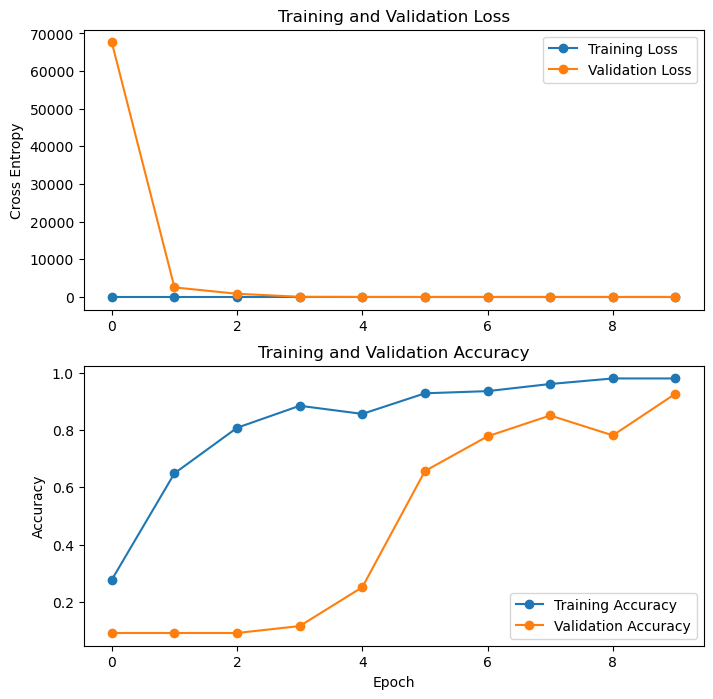

In [33]:
plot_history(history)

In [64]:
# Training takes time. Loading pre-trained weights (can be further improved...)
model.load_weights('best_model_RestNet50.weights.h5')
model.trainable = False

In [65]:
# Evaluate model on different datasets
train_loss, train_acc = model.evaluate(train_dataset)
val_loss, val_acc = model.evaluate(validation_dataset)

# Print results in a formatted manner
print(f"\nModel Performance Summary:")
print(f"Train -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.4%}")
print(f"Validation ->: Loss: {val_loss:.4f}, Accuracy: {val_acc:.4%}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9987 - loss: 0.0025
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9853 - loss: 0.0447

Model Performance Summary:
Train -> Loss: 0.0019, Accuracy: 99.9307%
Validation ->: Loss: 0.0710, Accuracy: 98.0583%
